<a href="https://colab.research.google.com/github/m-volnykh/BasisOfMachineLearning/blob/main/LR04.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Лабораторная работа №4: RFM-кластеризация покупателей

Выполнила Вольных М. В., 3 курс ИВТ, 2-1

## Подключение и загрузка данных

In [27]:
%%capture
!git clone https://github.com/m-volnykh/BasisOfMachineLearning

In [28]:
import zipfile

zip_file_path = '/content/BasisOfMachineLearning/Lab4.zip'
extract_path = 'extracted_files'

with zipfile.ZipFile(zip_file_path, 'r') as zip_ref:
    zip_ref.extractall(extract_path)

In [29]:
#импорт библиотек
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns

In [30]:
data = pd.read_csv('/content/extracted_files/customer_segmentation_project.csv')

data.head()

,InvoiceNo,StockCode,Description,Quantity,InvoiceDate,UnitPrice,CustomerID,Country
0,536365,85123A,WHITE HANGING HEART T-LIGHT HOLDER,6,12/1/2010 8:26,2.55,17850.0,United Kingdom
1,536365,71053,WHITE METAL LANTERN,6,12/1/2010 8:26,3.39,17850.0,United Kingdom
2,536365,84406B,CREAM CUPID HEARTS COAT HANGER,8,12/1/2010 8:26,2.75,17850.0,United Kingdom
3,536365,84029G,KNITTED UNION FLAG HOT WATER BOTTLE,6,12/1/2010 8:26,3.39,17850.0,United Kingdom
4,536365,84029E,RED WOOLLY HOTTIE WHITE HEART.,6,12/1/2010 8:26,3.39,17850.0,United Kingdom


## Обзор данных

### Первичный обзор

In [31]:
data.shape

(541909, 8)

In [32]:
data.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 541909 entries, 0 to 541908
Data columns (total 8 columns):
 #   Column       Non-Null Count   Dtype  
---  ------       --------------   -----  
 0   InvoiceNo    541909 non-null  object 
 1   StockCode    541909 non-null  object 
 2   Description  540455 non-null  object 
 3   Quantity     541909 non-null  int64  
 4   InvoiceDate  541909 non-null  object 
 5   UnitPrice    541909 non-null  float64
 6   CustomerID   406829 non-null  float64
 7   Country      541909 non-null  object 
dtypes: float64(2), int64(1), object(5)
memory usage: 33.1+ MB


Данные имеют пропуски: Description, CustomerID

In [33]:
print("Диапазон дат:", data['InvoiceDate'].min(), "до", data['InvoiceDate'].max())
print("Уникальных CustomerID:", data['CustomerID'].nunique())
print("Уникальных StockCode:", data['StockCode'].nunique())
print("Уникальных стран:", data['Country'].nunique())
print("\nТоп-5 стран по числу транзакций:")
print(data['Country'].value_counts().head())
print("\nПример кол-ва позиций в одном заказе (InvoiceNo=536365):")
print(data[data['InvoiceNo'] == '536365'].shape[0], "строк")
data[data['InvoiceNo'] == '536365'].head()

Диапазон дат: 1/10/2011 10:04 до 9/9/2011 9:52
Уникальных CustomerID: 4372
Уникальных StockCode: 4070
Уникальных стран: 38

Топ-5 стран по числу транзакций:
Country
United Kingdom    495478
Germany             9495
France              8557
EIRE                8196
Spain               2533
Name: count, dtype: int64

Пример кол-ва позиций в одном заказе (InvoiceNo=536365):
7 строк


,InvoiceNo,StockCode,Description,Quantity,InvoiceDate,UnitPrice,CustomerID,Country
0,536365,85123A,WHITE HANGING HEART T-LIGHT HOLDER,6,12/1/2010 8:26,2.55,17850.0,United Kingdom
1,536365,71053,WHITE METAL LANTERN,6,12/1/2010 8:26,3.39,17850.0,United Kingdom
2,536365,84406B,CREAM CUPID HEARTS COAT HANGER,8,12/1/2010 8:26,2.75,17850.0,United Kingdom
3,536365,84029G,KNITTED UNION FLAG HOT WATER BOTTLE,6,12/1/2010 8:26,3.39,17850.0,United Kingdom
4,536365,84029E,RED WOOLLY HOTTIE WHITE HEART.,6,12/1/2010 8:26,3.39,17850.0,United Kingdom


Поиск мпропусков и дубликатов

In [34]:
# Количество пропусков в каждом столбце
data.isna().sum()

,0
InvoiceNo,0
StockCode,0
Description,1454
Quantity,0
InvoiceDate,0
UnitPrice,0
CustomerID,135080
Country,0


In [35]:
# Удаление записей без CustomerID или Description
print("Удаляем записи с пустым CustomerID или Description...")
initial_rows = data.shape[0]
data = data.dropna(subset=['CustomerID', 'Description'])
print(f"Удалено строк с пустым CustomerID/Description: {initial_rows - data.shape[0]}")

# Поиск и удаление полных дубликатов
print("Ищем полные дубликаты...")
initial_rows = data.shape[0]
data = data.drop_duplicates()
print(f"Удалено полных дубликатов: {initial_rows - data.shape[0]}")
print("Размер данных после очистки:", data.shape)

Удаляем записи с пустым CustomerID или Description...
Удалено строк с пустым CustomerID/Description: 135080
Ищем полные дубликаты...
Удалено полных дубликатов: 5225
Размер данных после очистки: (401604, 8)


### Вбросы и аномалии

In [36]:
# Статистики Quantity и UnitPrice
print(data[['Quantity','UnitPrice']].describe(percentiles=[0.01,0.05,0.95,0.99]))

# Сколько транзакций с отрицательным Quantity (возвраты)?
print("\nКоличество строк с Quantity < 0 (возвраты):", (data['Quantity'] < 0).sum())

# Сколько транзакций с ценой 0?
print("\nКоличество строк с UnitPrice = 0 (бесплатно):", (data['UnitPrice'] == 0).sum())

# Пример очень больших Quantity
print("\nТоп-5 по Quantity:")
print(data.nlargest(5,'Quantity')[['InvoiceNo','StockCode','Description','Quantity','UnitPrice']])

            Quantity      UnitPrice
count  401604.000000  401604.000000
mean       12.183273       3.474064
std       250.283037      69.764035
min    -80995.000000       0.000000
1%         -2.000000       0.210000
5%          1.000000       0.420000
50%         5.000000       1.950000
95%        36.000000       8.500000
99%       120.000000      15.000000
max     80995.000000   38970.000000

Количество строк с Quantity < 0 (возвраты): 8872

Количество строк с UnitPrice = 0 (бесплатно): 40

Топ-5 по Quantity:
       InvoiceNo StockCode                        Description  Quantity  \
540421    581483     23843        PAPER CRAFT , LITTLE BIRDIE     80995   
61619     541431     23166     MEDIUM CERAMIC TOP STORAGE JAR     74215   
502122    578841     84826     ASSTD DESIGN 3D PAPER STICKERS     12540   
421632    573008     84077  WORLD WAR 2 GLIDERS ASSTD DESIGNS      4800   
206121    554868     22197               SMALL POPCORN HOLDER      4300   

        UnitPrice  
540421       

## Подготовка данных

### Удаление пропусков и дубликатов

In [37]:
# Удалим транзакции с Quantity = 0 или UnitPrice = 0, если есть
initial_rows = data.shape[0]
data = data[(data['Quantity'] != 0) & (data['UnitPrice'] != 0)]
print(f"Удалено строк с Quantity=0 или UnitPrice=0: {initial_rows - data.shape[0]}")

# Проверим, сколько отрицательных Quantity осталось
print("Отрицательных Quantity осталось:", (data['Quantity'] < 0).sum())


Удалено строк с Quantity=0 или UnitPrice=0: 40
Отрицательных Quantity осталось: 8872


### Формирование признаков

In [38]:
# Добавляем столбец общей стоимости по строке (цена * количество)
data['TotalPrice'] = data['UnitPrice'] * data['Quantity']

# Контроль: средняя и суммарная выручка по данным после очистки
print("Средняя сумма по строке:", round(data['TotalPrice'].mean(), 2))
print("Общая сумма всех транзакций:", round(data['TotalPrice'].sum(), 2))

Средняя сумма по строке: 20.62
Общая сумма всех транзакций: 8278519.42


<ipython-input-38-da9dd79237fe>:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  data['TotalPrice'] = data['UnitPrice'] * data['Quantity']


In [39]:
# Преобразуем InvoiceDate в datetime, если еще не преобразован
data['InvoiceDate'] = pd.to_datetime(data['InvoiceDate'])

# Определяем reference_date как день после последней даты в данных
reference_date = data['InvoiceDate'].max() + pd.Timedelta(days=1)

# Готовим агрегирование:
# Для Frequency используем только положительные транзакции (иначе возврат повысит Frequency)
sales_data = data[data['InvoiceNo'].str.startswith('C') == False]

rfm = sales_data.groupby('CustomerID').agg(
    Recency=('InvoiceDate', lambda x: (reference_date - x.max()).days),
    Frequency=('InvoiceNo', 'nunique')
    ).reset_index()

# Monetary считаем по ВСЕМ данным (с учетом возвратов)
monetary = data.groupby('CustomerID').agg(Monetary=('TotalPrice','sum')
    ).reset_index()

# Объединяем таблицы
rfm = pd.merge(rfm, monetary, on='CustomerID', how='left'
    ).fillna({'Recency': np.nan,'Frequency': 0, 'Monetary': 0})

print("Пример RFM для первых 5 клиентов:")
rfm.head(5)

Пример RFM для первых 5 клиентов:


,CustomerID,Recency,Frequency,Monetary
0,12346.0,326,1,0.00
1,12347.0,2,7,4310.00
2,12348.0,75,4,1797.24
3,12349.0,19,1,1757.55
4,12350.0,310,1,334.40


In [40]:
print("Всего клиентов в RFM таблице:", rfm.shape[0])
print("Есть ли клиенты с отрицательным Monetary?", (rfm['Monetary'] < 0).any())

Всего клиентов в RFM таблице: 4338
Есть ли клиенты с отрицательным Monetary? True


### Анализ распределений RFM и обработка выбросов

Визуализация данных

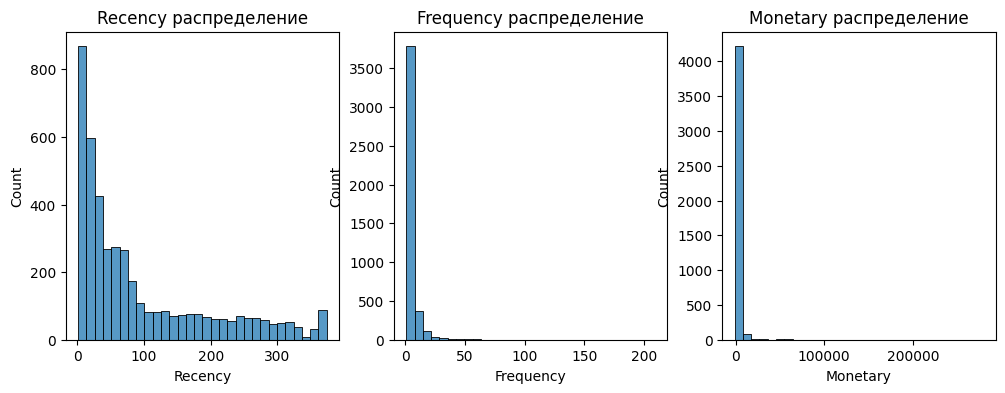

In [41]:
plt.figure(figsize=(12,4))
plt.subplot(1,3,1)
sns.histplot(rfm['Recency'], bins=30)
plt.title("Recency распределение")
plt.subplot(1,3,2)
sns.histplot(rfm['Frequency'], bins=30)
plt.title("Frequency распределение")
plt.subplot(1,3,3)
sns.histplot(rfm['Monetary'], bins=30)
plt.title("Monetary распределение")
plt.show()

In [42]:
# Посмотрим статистики и 95-99 перцентили
print(rfm[['Recency','Frequency','Monetary']].describe(percentiles=[0.95,0.99]))

           Recency    Frequency       Monetary
count  4338.000000  4338.000000    4338.000000
mean     92.536422     4.272015    1910.772398
std     100.014169     7.697998    8248.237548
min       1.000000     1.000000   -1165.300000
50%      51.000000     2.000000     649.955000
95%     312.000000    13.000000    5619.928000
99%     369.000000    30.000000   17399.630300
max     374.000000   209.000000  279489.020000


Удаление экстремальных значений

In [43]:
# Фильтр от выбросов
rfm_filtered = rfm[(rfm['Frequency'] <= 30) & (rfm['Monetary'] <= 20000)].copy()
print("Удалено клиентов-выбросов:", rfm.shape[0] - rfm_filtered.shape[0])

# Проверим размеры и описательные статистики после фильтрации
print("Оставшихся клиентов:", rfm_filtered.shape[0])
print(rfm_filtered[['Recency','Frequency','Monetary']].describe())


Удалено клиентов-выбросов: 59
Оставшихся клиентов: 4279
           Recency    Frequency      Monetary
count  4279.000000  4279.000000   4279.000000
mean     93.581912     3.697125   1330.778984
std     100.088118     4.029330   1947.734380
min       1.000000     1.000000  -1165.300000
25%      18.000000     1.000000    294.270000
50%      52.000000     2.000000    640.500000
75%     144.500000     4.000000   1544.880000
max     374.000000    30.000000  18793.410000


Стандартизация признаков перед кластеризацией

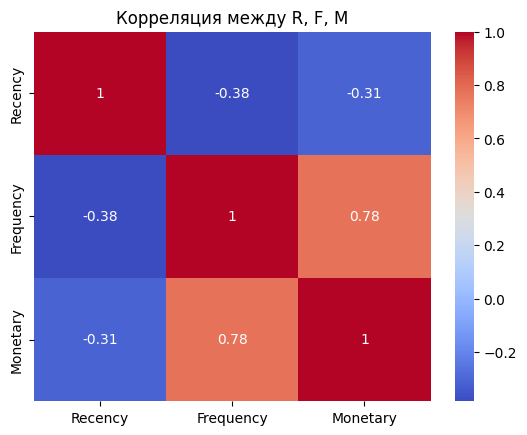

In [44]:
from sklearn.preprocessing import StandardScaler

# Стандартизация признаков RFM
scaler = StandardScaler()
rfm_scaled = scaler.fit_transform(rfm_filtered[['Recency','Frequency','Monetary']])

# Корреляционная матрица RFM
corr_matrix = rfm_filtered[['Recency','Frequency','Monetary']].corr()
sns.heatmap(corr_matrix, annot=True, cmap="coolwarm")
plt.title("Корреляция между R, F, M")
plt.show()

## Моделирование

### Метод локтя и Коэффициент силуэта

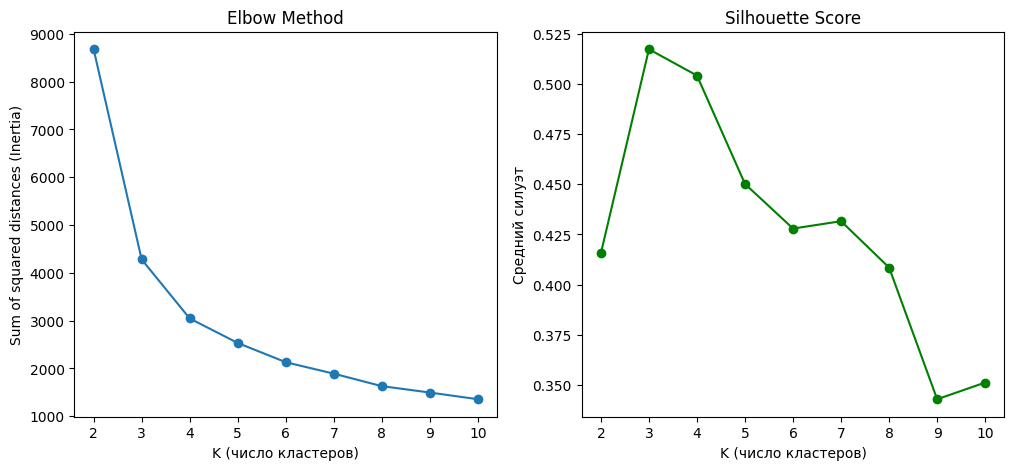

Лучший K по силуэту: 3 с оценкой 0.517


In [45]:
from sklearn.cluster import KMeans
from sklearn.metrics import silhouette_score

Ks = range(2, 11)
inertias = []
sil_scores = []

for k in Ks:
    kmeans = KMeans(n_clusters=k, init='k-means++', random_state=42)
    kmeans.fit(rfm_scaled) # обучение модели на стандартизированных данных
    inertias.append(kmeans.inertia_)
    # Оценка качества кластеризации силуэтом:
    labels = kmeans.labels_
    sil_scores.append(silhouette_score(rfm_scaled, labels))

# Визуализация метрики локтя и силуэта
plt.figure(figsize=(12,5))
plt.subplot(1,2,1)
plt.plot(list(Ks), inertias, marker='o')
plt.title("Elbow Method")
plt.xlabel("K (число кластеров)")
plt.ylabel("Sum of squared distances (Inertia)")
plt.subplot(1,2,2)
plt.plot(list(Ks), sil_scores, marker='o', color='green')
plt.title("Silhouette Score")
plt.xlabel("K (число кластеров)")
plt.ylabel("Средний силуэт")
plt.show()

# Найдем максимальный силуэт и соответствующий K
best_k = Ks[sil_scores.index(max(sil_scores))]
print("Лучший K по силуэту:", best_k, "с оценкой", round(max(sil_scores), 3))


### Применение K-Means с оптимальным K

In [46]:
optimal_k = best_k
kmeans_model = KMeans(n_clusters=optimal_k, init='k-means++', random_state=42)
cluster_labels = kmeans_model.fit_predict(rfm_scaled)

# Добавим метки кластеров в таблицу rfm_filtered
rfm_filtered['Cluster'] = cluster_labels

# Посмотрим, сколько клиентов в каждом кластерe
print("Распределение количества клиентов по кластерам:")
print(rfm_filtered['Cluster'].value_counts())


Распределение количества клиентов по кластерам:
Cluster
0    2824
1    1072
2     383
Name: count, dtype: int64


### Визуализация кластеров

**Pairplot**

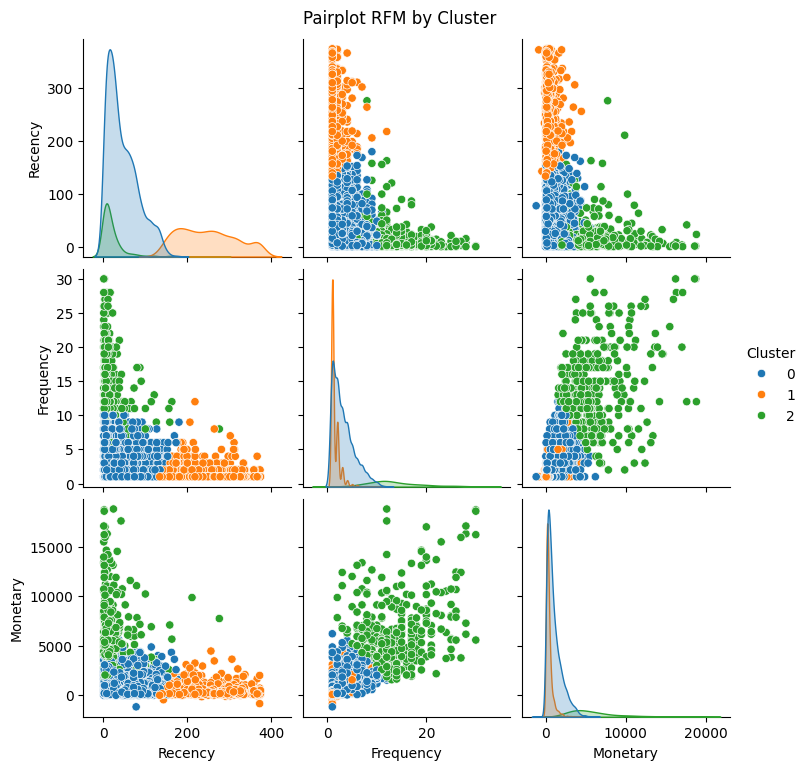

In [47]:
sns.pairplot(rfm_filtered, vars=['Recency','Frequency','Monetary'],
             hue='Cluster',palette='tab10')
plt.suptitle("Pairplot RFM by Cluster", y=1.02)
plt.show()

**2D PCA проекция**

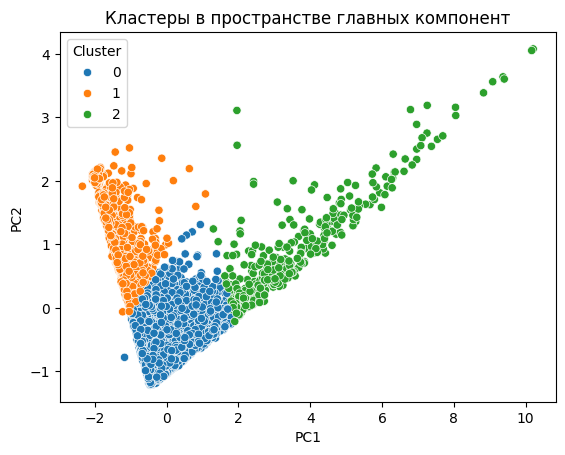

In [48]:
from sklearn.decomposition import PCA

pca = PCA(n_components=2)
rfm_pca = pca.fit_transform(rfm_scaled)
# DataFrame для удобства
pca_df = pd.DataFrame(rfm_pca, columns=['PC1','PC2'], index=rfm_filtered.index)
pca_df['Cluster'] = rfm_filtered['Cluster']

sns.scatterplot(data=pca_df, x='PC1', y='PC2', hue='Cluster', palette='tab10')
plt.title("Кластеры в пространстве главных компонент")
plt.show()

**UMAP проекция**

In [49]:
%%capture
!pip install umap-learn

/usr/local/lib/python3.11/dist-packages/sklearn/utils/deprecation.py:151: FutureWarning: 'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
  warnings.warn(
/usr/local/lib/python3.11/dist-packages/umap/umap_.py:1952: UserWarning: n_jobs value 1 overridden to 1 by setting random_state. Use no seed for parallelism.
  warn(


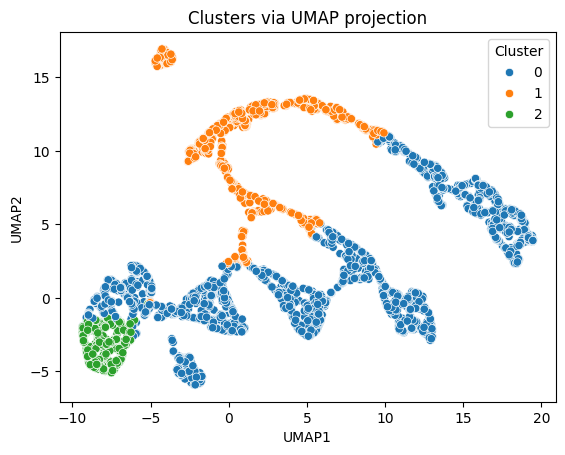

In [50]:
import umap

# Обучаем UMAP на стандартизированных данных
reducer = umap.UMAP(n_neighbors=15, min_dist=0.1, random_state=42)
rfm_umap = reducer.fit_transform(rfm_scaled)
umap_df = pd.DataFrame(rfm_umap, columns=['UMAP1','UMAP2'], index=rfm_filtered.index)
umap_df['Cluster'] = rfm_filtered['Cluster']

sns.scatterplot(data=umap_df, x='UMAP1', y='UMAP2', hue='Cluster', palette='tab10')
plt.title("Clusters via UMAP projection")
plt.show()


In [51]:
cluster_summary = rfm_filtered.groupby('Cluster').agg({
                  'Recency': 'mean',
                  'Frequency': 'mean',
                  'Monetary': 'mean',
                  'CustomerID': 'count' # число клиентов в кластере
                  }).rename(columns={'CustomerID': 'NumCustomers'})
cluster_summary = cluster_summary.round(1)
cluster_summary

,Recency,Frequency,Monetary,NumCustomers
Cluster,,,,
0,45.2,3.2,1042.3,2824
1,247.3,1.5,419.7,1072
2,19.8,13.5,6008.0,383


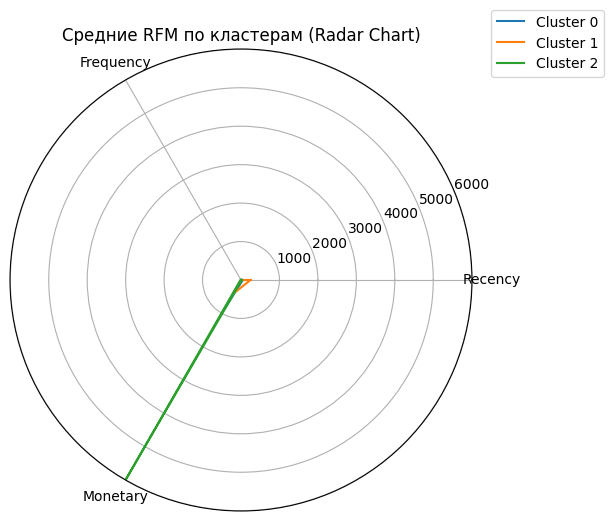

In [52]:
# Список категорий
categories = ['Recency','Frequency','Monetary']
num_vars = len(categories)

# Угол для каждой категории в радианах
angles = [n / float(num_vars) * 2 * np.pi for n in range(num_vars)]
angles += [angles[0]] # замыкаем круг

# Подготовка полотна
plt.figure(figsize=(6,6))
ax = plt.subplot(111, polar=True)

# Чертим одну окружность для максимального значения (можно взять максимумы из cluster_summary)
max_values = cluster_summary[categories].max().values
ax.set_ylim(0, max(max_values)) # радиальная шкала от 0 до максимума среди средних

# Подписи осей по кругу
plt.xticks(angles[:-1], categories)

# Для каждого кластера строим линию
for cluster, row in cluster_summary.iterrows():
    values = row[categories].tolist()
    values += [values[0]] # повторяем первый показатель в конец для замыкания
    ax.plot(angles, values, label=f'Cluster {cluster}')
    ax.fill(angles, values, alpha=0.1)

plt.title("Средние RFM по кластерам (Radar Chart)")
plt.legend(loc='upper right', bbox_to_anchor=(1.3, 1.1))
plt.show()

## Оценка результатов

Коэффициент Recency имеет обратную зависимость с коэффициентами Frequency и Monetary.

**Интерпретация кластеров:**

*   *Cluster 0* - средние Recency, Frequency и Monetary - *"Регулярные покупатели"*
*   *Cluster 1* - высокая Recency, низкие Frequency и Monetary - *"Разовые / Ушедшие клиенты"*
*   *Cluster 2* - низкая Recency, достаточно высокие Frequency и Monetary - *"Лучшие клиенты"*




